In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import misc
from urllib.request import urlretrieve
from tqdm import tqdm
import zipfile
import shutil

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

#### download pretrained from [here](https://drive.google.com/file/d/1MMkvnvPKQt-iHuNmgR1-2SfXGiJWv47B/view?usp=sharing), and unzip in the same directory.

In [2]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

def maybe_download_pretrained_vgg(data_dir):
    vgg_filename = 'vgg.zip'
    vgg_path = os.path.join(data_dir, 'vgg')
    vgg_files = [
        os.path.join(vgg_path, 'variables/variables.data-00000-of-00001'),
        os.path.join(vgg_path, 'variables/variables.index'),
        os.path.join(vgg_path, 'saved_model.pb')]

    missing_vgg_files = [vgg_file for vgg_file in vgg_files if not os.path.exists(vgg_file)]
    if missing_vgg_files:
        # Clean vgg dir
        if os.path.exists(vgg_path):
            shutil.rmtree(vgg_path)
        os.makedirs(vgg_path)

        # Download vgg
        print('Downloading pre-trained vgg model...')
        with DLProgress(unit='B', unit_scale=True, miniters=1) as pbar:
            urlretrieve(
                'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/vgg.zip',
                os.path.join(vgg_path, vgg_filename),
                pbar.hook)

        # Extract vgg
        print('Extracting model...')
        zip_ref = zipfile.ZipFile(os.path.join(vgg_path, vgg_filename), 'r')
        zip_ref.extractall(data_dir)
        zip_ref.close()

        # Remove zip file to save space
        os.remove(os.path.join(vgg_path, vgg_filename))


In [3]:
maybe_download_pretrained_vgg('data/')

In [4]:
def load_vgg(sess, vgg_path):
    # Define the name of the tensors
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'

    # Get the needed layers' outputs for building FCN-VGG16
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    image_input = tf.get_default_graph().get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = tf.get_default_graph().get_tensor_by_name(vgg_keep_prob_tensor_name)
    vgg_layer3_out = tf.get_default_graph().get_tensor_by_name(vgg_layer3_out_tensor_name)
    vgg_layer4_out = tf.get_default_graph().get_tensor_by_name(vgg_layer4_out_tensor_name)
    vgg_layer7_out = tf.get_default_graph().get_tensor_by_name(vgg_layer7_out_tensor_name)

    return image_input, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out



def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    # making sure the resulting shape are the same
    vgg_layer7_logits = tf.layers.conv2d(
        vgg_layer7_out, num_classes, kernel_size=1,
        kernel_initializer= tf.random_normal_initializer(stddev=0.01),
        kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-4), name='vgg_layer7_logits')
    vgg_layer4_logits = tf.layers.conv2d(
        vgg_layer4_out, num_classes, kernel_size=1,
        kernel_initializer= tf.random_normal_initializer(stddev=0.01),
        kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-4), name='vgg_layer4_logits')
    vgg_layer3_logits = tf.layers.conv2d(
        vgg_layer3_out, num_classes, kernel_size=1,
        kernel_initializer= tf.random_normal_initializer(stddev=0.01),
        kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-4), name='vgg_layer3_logits')

    # # Apply the transposed convolutions to get upsampled version, and then merge the upsampled layers
    fcn_decoder_layer1 = tf.layers.conv2d_transpose(
        vgg_layer7_logits, num_classes, kernel_size=4, strides=(2, 2),
        padding='same',
        kernel_initializer= tf.random_normal_initializer(stddev=0.01),
        kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-4), name='fcn_decoder_layer1')

    # add the first skip connection from the vgg_layer4_out
    fcn_decoder_layer2 = tf.add(
        fcn_decoder_layer1, vgg_layer4_logits, name='fcn_decoder_layer2')

    # then follow this with another transposed convolution layer and make shape the same as layer3
    fcn_decoder_layer3 = tf.layers.conv2d_transpose(
        fcn_decoder_layer2, num_classes, kernel_size=4, strides=(2, 2),
        padding='same',
        kernel_initializer= tf.random_normal_initializer(stddev=0.01),
        kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-4), name='fcn_decoder_layer3')

    # apply the same steps for the third layer output.
    fcn_decoder_layer4 = tf.add(
        fcn_decoder_layer3, vgg_layer3_logits, name='fcn_decoder_layer4')
    fcn_decoder_output = tf.layers.conv2d_transpose(
        fcn_decoder_layer4, num_classes, kernel_size=16, strides=(8, 8),
        padding='same',
        kernel_initializer= tf.random_normal_initializer(stddev=0.01),
        kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-4), name='fcn_decoder_layer4')

    return fcn_decoder_output

In [5]:
num_classes = 2
image_shape = (160, 576)
vgg_path = os.path.join('./data', 'vgg')
model_path='./model/model.ckpt'
image_path = 'img_1960.jpg'

In [6]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, vgg_path)
nn_last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)
logits = tf.reshape(nn_last_layer, (-1, num_classes))

saver = tf.train.Saver()
saver.restore(sess, model_path)

INFO:tensorflow:Restoring parameters from ./data/vgg/variables/variables
INFO:tensorflow:Restoring parameters from ./model/model.ckpt


In [7]:
image = misc.imresize(misc.imread(image_path), image_shape)
im_softmax = sess.run([tf.nn.softmax(logits)],{keep_prob: 1.0, input_image: [image]})
im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
mask = misc.toimage(mask, mode="RGBA")
street_im = misc.toimage(image)
street_im.paste(mask, box=None, mask=mask)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray

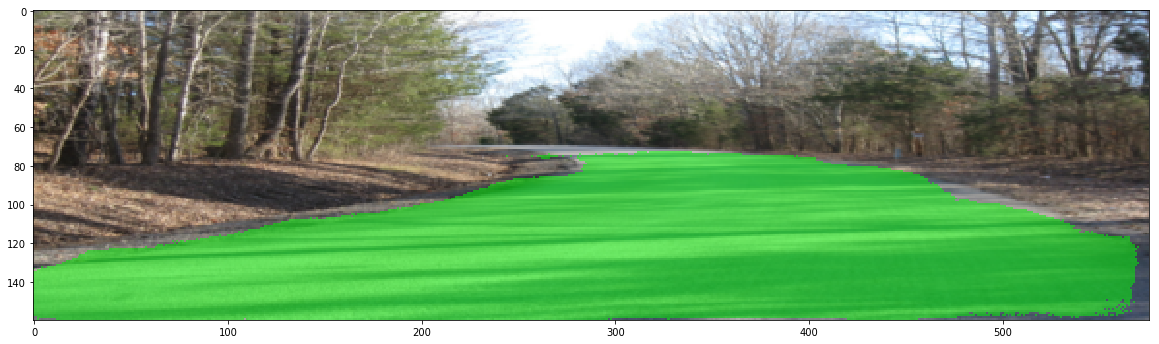

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(street_im)
plt.show()

In [21]:
nonzero = (im_softmax > 0.5).nonzero()
y = nonzero[0]
x = nonzero[1]

In [29]:
y_unique = np.unique(y)
y_unique

array([ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159])

In [30]:
x[(y == 73)]

array([312, 313, 314, 315, 316, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339])

In [33]:
left_x, left_y = [], []
right_x, right_y = [], []

for u in y_unique:
    filtered = x[(y == u)]
    left_y.append(u)
    right_y.append(u)
    left_x.append(filtered.min())
    right_x.append(filtered.max())

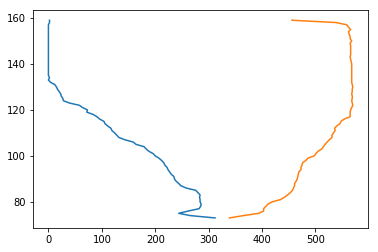

In [45]:
plt.plot(left_x, left_y)
plt.plot(right_x, right_y)

In [42]:
from scipy import signal

In [48]:
left_x_savgol = signal.savgol_filter(left_x, 53, 3)
right_x_savgol = signal.savgol_filter(right_x, 53, 3)

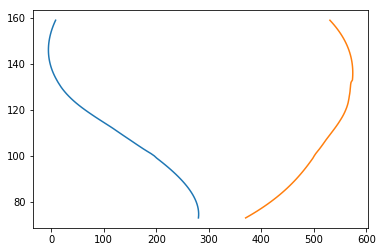

In [49]:
plt.plot(left_x_savgol, left_y)
plt.plot(right_x_savgol, right_y)

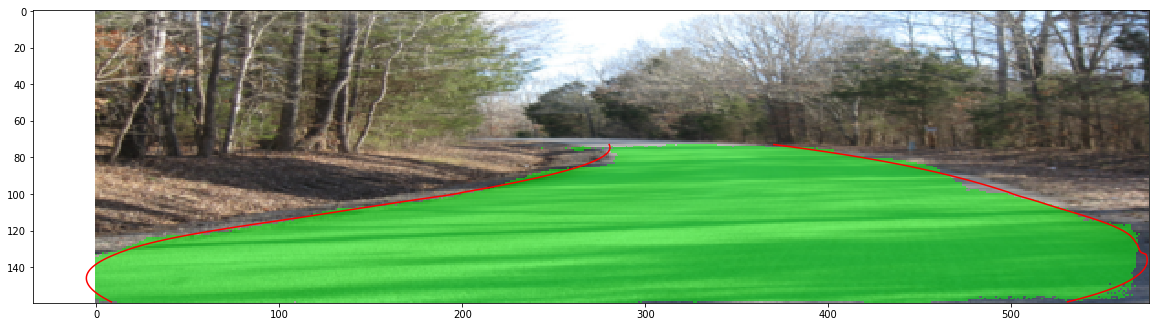

In [50]:
plt.figure(figsize=(20,10))
plt.imshow(street_im)
plt.plot(left_x_savgol, left_y, c='r')
plt.plot(right_x_savgol, right_y, c='r')
plt.show()

In [53]:
middle_road = (right_x_savgol - left_x_savgol) // 2 + left_x_savgol

In [60]:
left_path = (middle_road - left_x_savgol) // 2 + left_x_savgol
right_path = (right_x_savgol - middle_road) // 2 + middle_road

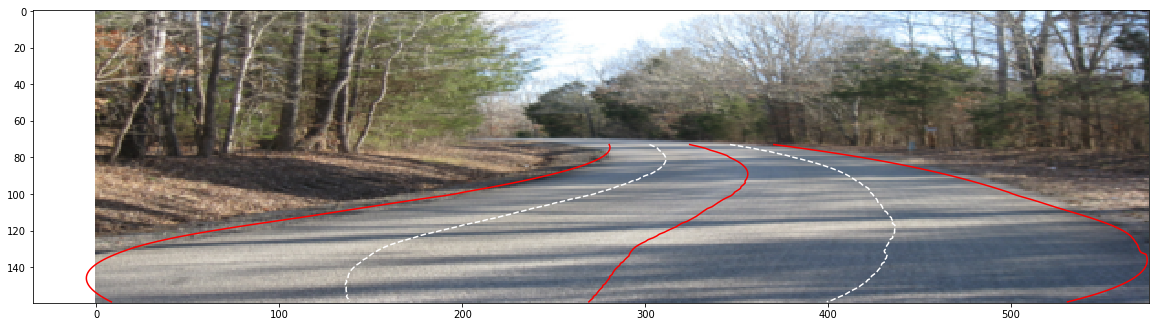

In [62]:
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.plot(left_x_savgol, left_y, c='r')
plt.plot(right_x_savgol, right_y, c='r')
plt.plot(middle_road, right_y, c='r')
plt.plot(left_path, right_y, '--', c='w')
plt.plot(right_path, right_y, '--', c='w')
plt.show()